<a href="https://colab.research.google.com/github/jithamanyu001/CV/blob/main/Neural_Style_Transfrer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Neural Style Transfer**

NST is a very amazing technique to convert images into an artistic form. If u want to make an image into a particular style we will need an image in that style to create a GAN like model. But it is a very time taking process and require lot of computation and parameters. But insted basing it on the approach of DEEPDREAM one could extranct the cstyle and content features and use them to make changes to the image itself. This is how NST works

In [ ]:
import tensorflow as tf
from google.colab.patches import cv2_imshow
from tensorflow.keras.applications import vgg16
import numpy as np
import PIL

In [ ]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

195196/195196 [==============================] - 0s 0us/step


In [ ]:
model=vgg16.VGG16(include_top=False)

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
content_layers=["block5_conv2"]
style_layers=["block1_conv2","block2_conv2","block3_conv3","block4_conv3"]
content_output=[
    model.get_layer(name).output for name in content_layers
]
style_output=[
    model.get_layer(name).output for name in style_layers
]
content_feature=tf.keras.Model(inputs=model.input,outputs=content_output)
style_feature=tf.keras.Model(inputs=model.input,outputs=style_output)
content_feature.trainable=False
style_feature.trainable=False

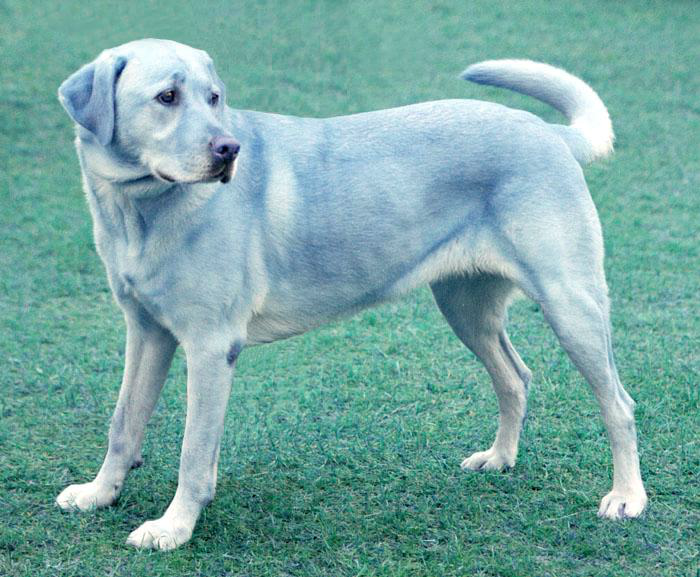

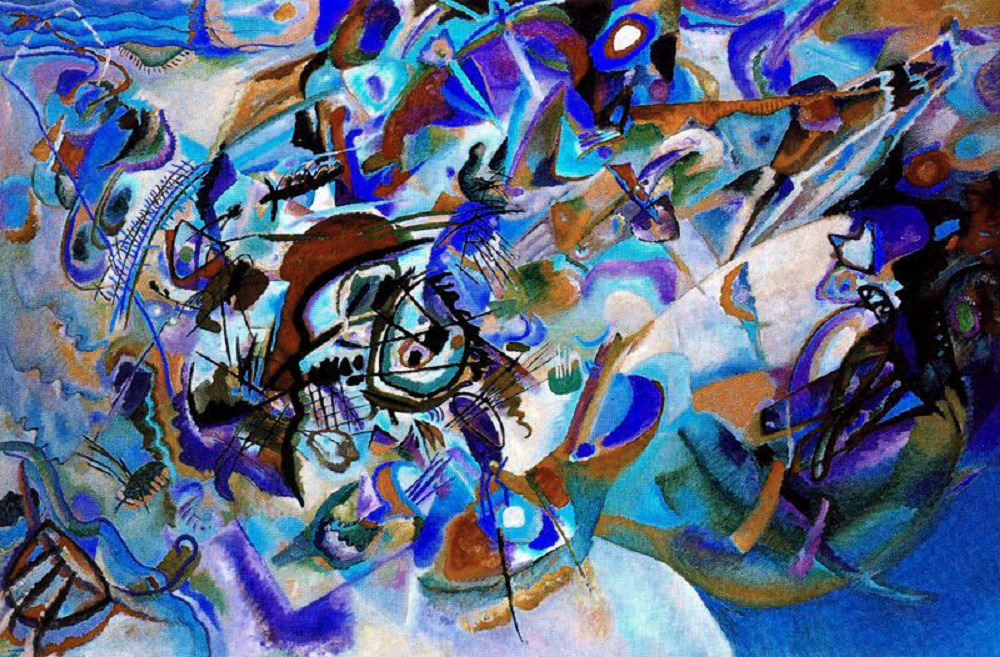

In [ ]:
content_img=tf.keras.utils.load_img(content_path)
content_img=tf.keras.utils.img_to_array(content_img)
content_img=content_img.reshape((1,)+content_img.shape)
cv2_imshow(content_img[0])
style_img=tf.keras.utils.load_img(style_path)
style_img=tf.keras.utils.img_to_array(style_img)
style_img=style_img.reshape((1,)+style_img.shape)
cv2_imshow(style_img[0])

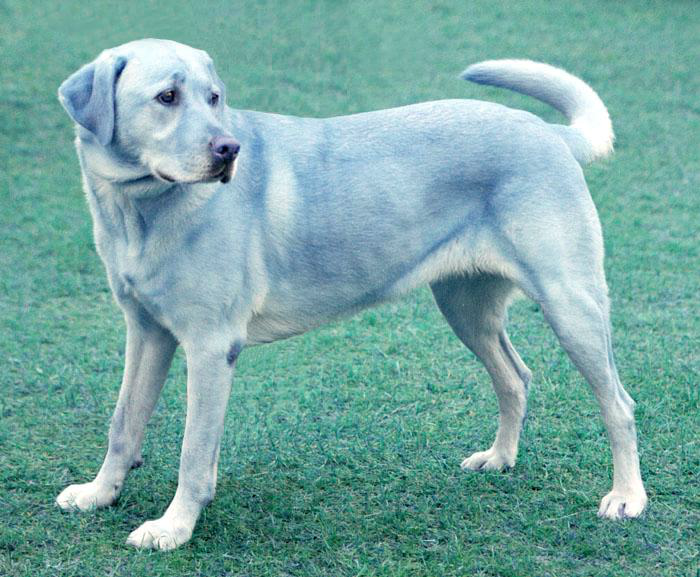

In [ ]:
img=tf.Variable(content_img)
tensor_to_image(img)
cv2_imshow(img.numpy()[0])

In [ ]:
sty_target=style_feature(vgg16.preprocess_input(style_img))
cont_target=content_feature(vgg16.preprocess_input(content_img))

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

def calc_loss(img):
  style_outs=style_feature(vgg16.preprocess_input(img))
  content_outs=content_feature(vgg16.preprocess_input(img))
  content_loss= 1e4 * tf.add_n([tf.reduce_mean((content_outs[i] - cont_target[i])**2) for i in range(len(content_outs))])
  style_loss= 1e-2 * tf.add_n([tf.reduce_mean(((gram_matrix(style_outs[i]) - gram_matrix(sty_target[i]))**2)) for i in range(len(style_outs))]) 
  var_x=img[:,:,1:,:]-img[:,:,:-1,:]
  var_y=img[:,1:,:,:]-img[:,:-1,:,:]
  tot_var_loss=30 * tf.reduce_sum(tf.abs(var_x))+tf.reduce_sum(tf.abs(var_y))
  tot_loss= content_loss + style_loss + tot_var_loss
  return tot_loss
  

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
def grad_ascent(img):
  with tf.GradientTape() as tape:
    tape.watch(img)
    loss=calc_loss(img)
  grad = tape.gradient(loss, img)
  opt.apply_gradients([(grad, img)])
  img.assign(img)


In [69]:
img=tf.Variable(img)
grad_ascent(img)
grad_ascent(img)
grad_ascent(img)
grad_ascent(img)
grad_ascent(img)

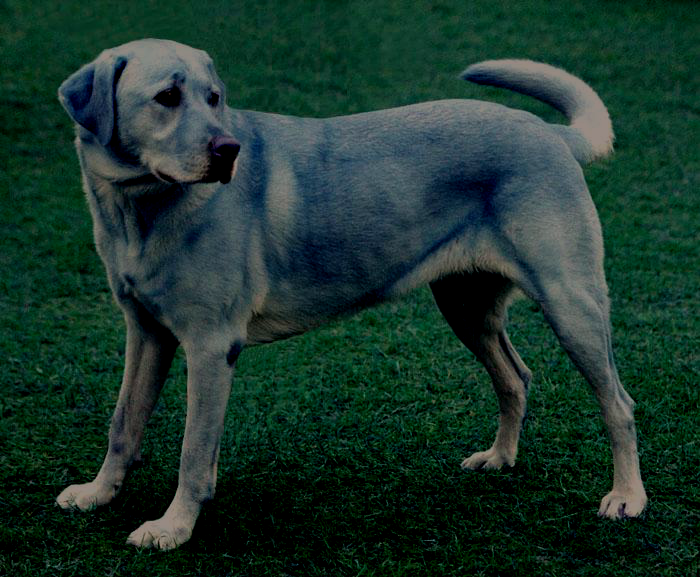

In [70]:
cv2_imshow(img.numpy()[0])